In [43]:
%load_ext autoreload
%autoreload 2

from pytorch3d.io import load_objs_as_meshes
import torch

from text3d2video.camera_placement import front_facing_extrinsics
from text3d2video.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

from text3d2video.util import read_obj_uvs

torch.set_grad_enabled(False)

# read mesh
mesh_path = "data/meshes/mixamo-human.obj"

device = "cuda"
meshes = load_objs_as_meshes([mesh_path], device=device)
meshes = normalize_meshes(meshes)
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)

print('verts', meshes.verts_list()[0].shape)
print('faces', meshes.faces_list()[0].shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
verts torch.Size([14442, 3])
faces torch.Size([28880, 3])


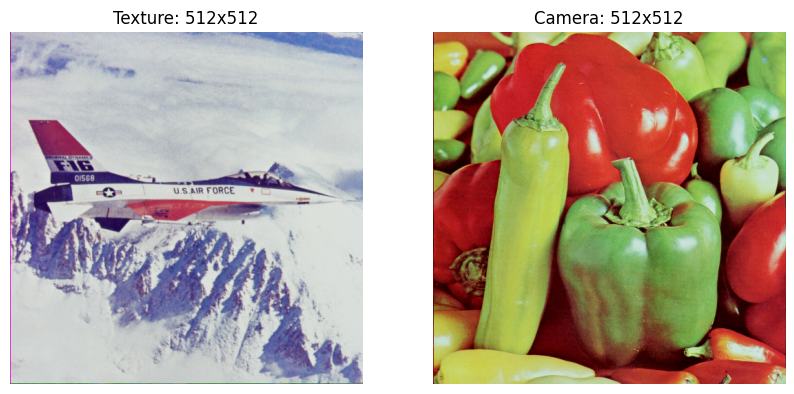

In [21]:
from matplotlib import pyplot as plt
import torch
from pytorch3d.renderer import TexturesUV
from torchvision.io import read_image

texture_image = read_image("data/images/airplane.png") / 255
texture_image = texture_image.permute(1, 2, 0).to(device)

camera_image = read_image("data/images/peppers.png") / 255
camera_image = camera_image.permute(1, 2, 0).to(device)

TEXTURE_RES = texture_image.shape[0]
CAMERA_RES = camera_image.shape[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax_tex = axs[0]
ax_cam = axs[1]

ax_tex.set_title(f"Texture: {TEXTURE_RES}x{TEXTURE_RES}")
ax_tex.imshow(texture_image.cpu().numpy())

ax_cam.set_title(f"Camera: {CAMERA_RES}x{CAMERA_RES}")
ax_cam.imshow(camera_image.cpu().numpy())

for ax in axs:
    ax.axis("off")

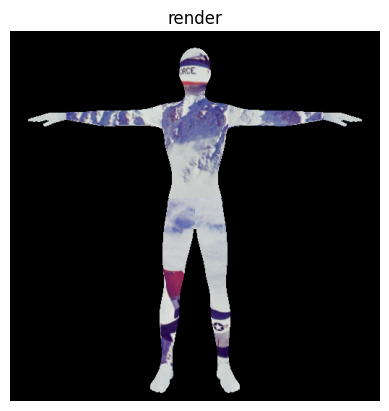

In [22]:
from text3d2video.rendering import make_feature_renderer

R, T = front_facing_extrinsics()
cam = FoVPerspectiveCameras(R=R, T=T, device=device, fov=40)

textures = TexturesUV(
    maps=texture_image.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
    faces_uvs=faces_uvs.unsqueeze(0),
)

meshes.textures = textures

renderer = make_feature_renderer(cameras=cam, resolution=512, device=device)
render = renderer(meshes)

plt.title("render")
plt.imshow(render[0].cpu())
plt.axis('off')
plt.show()

In [36]:
from text3d2video.util import project_uvs_to_cameras

xy_coords, uv_coords = project_uvs_to_cameras(
    meshes, cam, verts_uvs, faces_uvs, render_resolution=1000, texture_res=TEXTURE_RES
)

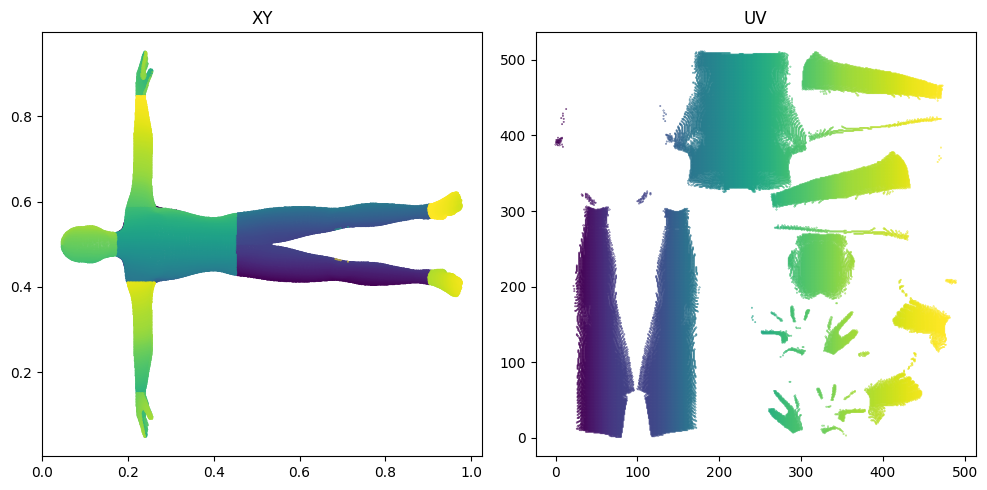

In [37]:
indices = torch.arange(0, xy_coords.shape[0], device=device)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax_xy = axs[0]
ax_uv = axs[1]

ax_uv.scatter(uv_coords[:, 0].cpu(), uv_coords[:, 1].cpu(), s=0.1, c=indices.cpu())
ax_uv.set_title("UV")

ax_xy.scatter(xy_coords[:, 0].cpu(), xy_coords[:, 1].cpu(), s=0.1, c=indices.cpu())
ax_xy.set_title("XY")

plt.tight_layout()
plt.show()

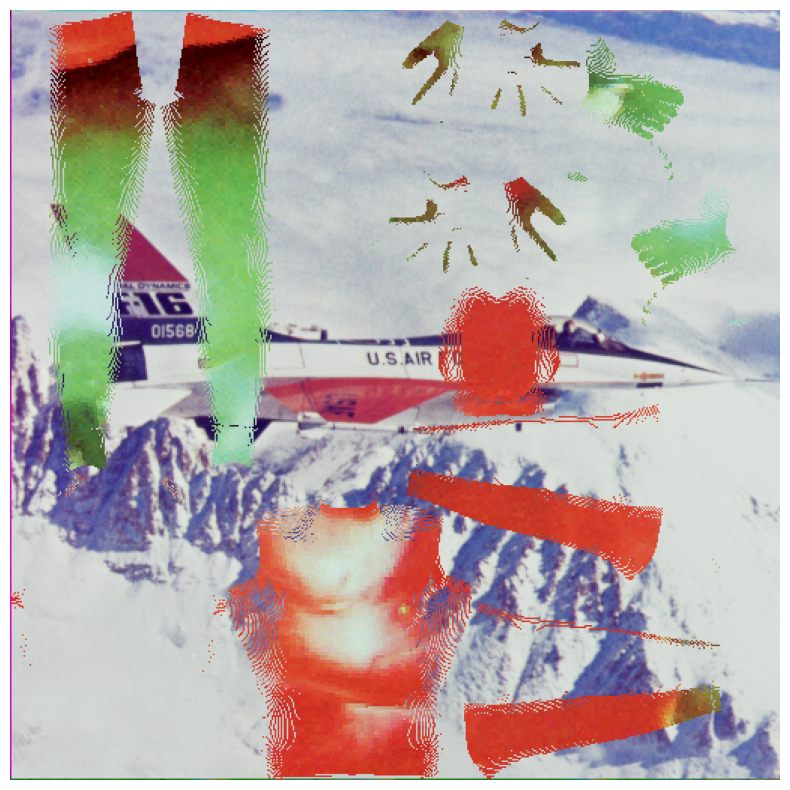

<Figure size 640x480 with 0 Axes>

In [38]:
from text3d2video.ipython_utils import display_ims
from text3d2video.util import sample_feature_map_ndc

camera_fmap = camera_image.permute(2, 0, 1)

xy_coords_ndc = xy_coords.clone()
coord_pix_xys_ndc = 2 * xy_coords_ndc - 1

colors = sample_feature_map_ndc(camera_fmap, xy_coords_ndc)
updated_texture = texture_image.clone()
updated_texture[uv_coords[:, 1], uv_coords[:, 0]] = colors

display_ims([updated_texture.cpu()], scale=10)

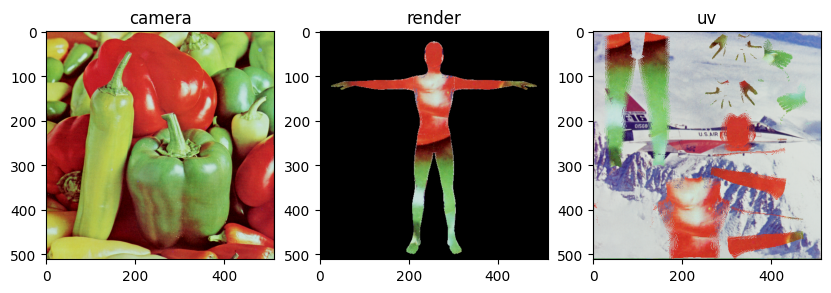

In [39]:
textures = TexturesUV(
    maps=updated_texture.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
    faces_uvs=faces_uvs.unsqueeze(0),
)

meshes.textures = textures

renderer = make_feature_renderer(cameras=cam, resolution=512, device=device)
render = renderer(meshes)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

ax_cam = axs[0]
ax_render = axs[1]
ax_uv = axs[2]


ax_render.set_title("render")
ax_render.imshow(render[0].cpu())

ax_cam.set_title("camera")
ax_cam.imshow(camera_image.cpu())

ax_uv.set_title("uv")
ax_uv.imshow(updated_texture.cpu())
